# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/kaggle/input/data-lenta/lenta_40k.csv')

In [3]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [5]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [7]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [8]:
len(filtered_vocab)

24091

In [9]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [12]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [13]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [14]:
X.shape

(44356, 200)

In [15]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [16]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [17]:
len(label2id)

19

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

#### модель с 1 GRU слоем

In [19]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

2023-02-15 17:57:10.691428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 17:57:10.692863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 17:57:10.944815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 17:57:10.945731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 17:57:10.946641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [20]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          callbacks=[callback],
          epochs=20)

2023-02-15 17:57:15.950230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-15 17:57:19.663986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 11s 105ms/step - loss: 2.4874 - f1: 1.8143e-04 - rec@prec: 0.0000e+00 - val_loss: 2.2248 - val_f1: 0.0000e+00 - val_rec@prec: 0.0027
Epoch 2/20
43/43 [==============================] - 4s 89ms/step - loss: 1.9788 - f1: 0.0859 - rec@prec: 0.0329 - val_loss: 1.7881 - val_f1: 0.2354 - val_rec@prec: 0.0807
Epoch 3/20
43/43 [==============================] - 4s 90ms/step - loss: 1.4423 - f1: 0.4348 - rec@prec: 0.2732 - val_loss: 1.4449 - val_f1: 0.4867 - val_rec@prec: 0.2619
Epoch 4/20
43/43 [==============================] - 4s 90ms/step - loss: 1.0416 - f1: 0.6466 - rec@prec: 0.5948 - val_loss: 1.3337 - val_f1: 0.5792 - val_rec@prec: 0.3729
Epoch 5/20
43/43 [==============================] - 4s 92ms/step - loss: 0.7437 - f1: 0.7728 - rec@prec: 0.7827 - val_loss: 1.2617 - val_f1: 0.6389 - val_rec@prec: 0.4779
Epoch 6/20
43/43 [==============================] - 4s 90ms/step - loss: 0.5135 - f1: 0.8510 - rec@prec: 0.8884 - val_loss: 1.3763 - val_f1: 0

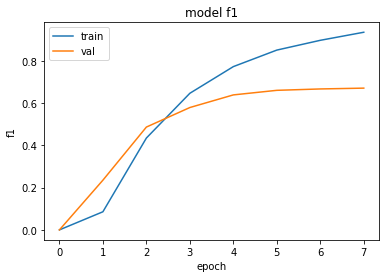

In [21]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Не очень

#### модель с 1 LSTM слоем

In [22]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [23]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          callbacks=[callback],
          epochs=20)

Epoch 1/20
43/43 [==============================] - 7s 122ms/step - loss: 2.4447 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2743 - val_f1: 0.0000e+00 - val_rec@prec: 0.0018
Epoch 2/20
43/43 [==============================] - 5s 111ms/step - loss: 1.9570 - f1: 0.1003 - rec@prec: 0.0455 - val_loss: 1.6480 - val_f1: 0.3061 - val_rec@prec: 0.1416
Epoch 3/20
43/43 [==============================] - 5s 112ms/step - loss: 1.3254 - f1: 0.5480 - rec@prec: 0.3751 - val_loss: 1.3901 - val_f1: 0.5322 - val_rec@prec: 0.3431
Epoch 4/20
43/43 [==============================] - 5s 111ms/step - loss: 1.0492 - f1: 0.6672 - rec@prec: 0.5813 - val_loss: 1.2443 - val_f1: 0.6209 - val_rec@prec: 0.3990
Epoch 5/20
43/43 [==============================] - 5s 112ms/step - loss: 0.8725 - f1: 0.7351 - rec@prec: 0.6987 - val_loss: 1.2863 - val_f1: 0.6253 - val_rec@prec: 0.4567
Epoch 6/20
43/43 [==============================] - 5s 113ms/step - loss: 0.7122 - f1: 0.7905 - rec@prec: 0.7930 - val_loss: 1.1

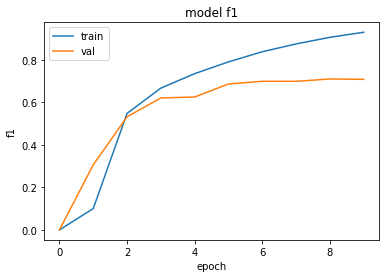

In [24]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Здесь лучше

#### модель с 1 GRU и 1 LSTM слоем

In [25]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_1)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [26]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          callbacks=[callback],
          epochs=20)

Epoch 1/20
43/43 [==============================] - 10s 168ms/step - loss: 2.4931 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2926 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 6s 143ms/step - loss: 1.9802 - f1: 0.0680 - rec@prec: 0.0370 - val_loss: 1.7879 - val_f1: 0.1566 - val_rec@prec: 0.1240
Epoch 3/20
43/43 [==============================] - 6s 143ms/step - loss: 1.4559 - f1: 0.4700 - rec@prec: 0.2699 - val_loss: 1.4332 - val_f1: 0.5256 - val_rec@prec: 0.3219
Epoch 4/20
43/43 [==============================] - 6s 143ms/step - loss: 1.1549 - f1: 0.6345 - rec@prec: 0.5017 - val_loss: 1.4043 - val_f1: 0.5619 - val_rec@prec: 0.3841
Epoch 5/20
43/43 [==============================] - 6s 143ms/step - loss: 0.9492 - f1: 0.7089 - rec@prec: 0.6445 - val_loss: 1.2846 - val_f1: 0.6350 - val_rec@prec: 0.4621
Epoch 6/20
43/43 [==============================] - 6s 145ms/step - loss: 0.8270 - f1: 0.7519 - rec@prec: 0.7236 - val_loss

<function matplotlib.pyplot.show(close=None, block=None)>

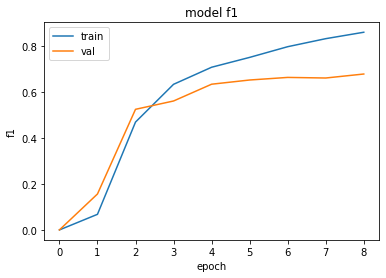

In [27]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

Становится чуть хуже

#### модель с 1 BIGRU и 2 LSTM слоями

In [28]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs, )

gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [29]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          callbacks=[callback],
          epochs=20)

Epoch 1/20
43/43 [==============================] - 20s 337ms/step - loss: 2.4010 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2471 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 14s 315ms/step - loss: 2.0058 - f1: 0.0468 - rec@prec: 0.0037 - val_loss: 1.8295 - val_f1: 0.2204 - val_rec@prec: 0.0063
Epoch 3/20
43/43 [==============================] - 14s 320ms/step - loss: 1.7393 - f1: 0.2564 - rec@prec: 0.0804 - val_loss: 1.7510 - val_f1: 0.2640 - val_rec@prec: 0.1303
Epoch 4/20
43/43 [==============================] - 14s 317ms/step - loss: 1.5528 - f1: 0.3925 - rec@prec: 0.2256 - val_loss: 1.6061 - val_f1: 0.4385 - val_rec@prec: 0.2101
Epoch 5/20
43/43 [==============================] - 13s 314ms/step - loss: 1.3061 - f1: 0.5662 - rec@prec: 0.4192 - val_loss: 1.3928 - val_f1: 0.5515 - val_rec@prec: 0.3837
Epoch 6/20
43/43 [==============================] - 13s 312ms/step - loss: 1.0688 - f1: 0.6790 - rec@prec: 0.6000 - val

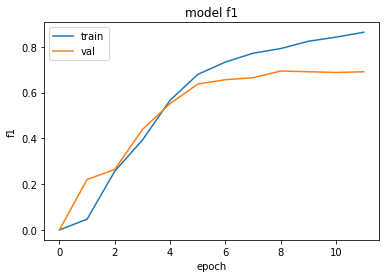

In [30]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

не очень

#### модель с 5 GRU слоями и 3 LSTM слоями

In [31]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [32]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          callbacks=[callback],
          epochs=20)

Epoch 1/20
43/43 [==============================] - 32s 538ms/step - loss: 2.3907 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3222 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 21s 495ms/step - loss: 2.3247 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3195 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 21s 489ms/step - loss: 2.3232 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3196 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
43/43 [==============================] - 21s 489ms/step - loss: 2.3223 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3213 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
43/43 [==============================] - 21s 493ms/step - loss: 2.3233 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3215 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00


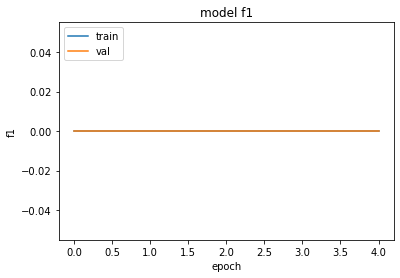

In [33]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Все плохо! видимо слишком много слоев для такой задачи

#### модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались

In [34]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs, )

gru = tf.keras.layers.Bidirectional(
                                    tf.keras.layers.GRU(128, return_sequences=True),
                        backward_layer=tf.keras.layers.GRU(256, return_sequences=True, 
                                                            go_backwards=True))(embeddings)
hidden = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=False),
                        backward_layer=tf.keras.layers.LSTM(256, return_sequences=False, 
                                                            go_backwards=True))(gru)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [35]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          callbacks=[callback],
          epochs=20)

Epoch 1/20
43/43 [==============================] - 35s 694ms/step - loss: 2.2836 - f1: 6.1276e-04 - rec@prec: 0.0043 - val_loss: 1.9409 - val_f1: 0.0573 - val_rec@prec: 0.0469
Epoch 2/20
43/43 [==============================] - 28s 661ms/step - loss: 1.6581 - f1: 0.2189 - rec@prec: 0.1169 - val_loss: 1.5843 - val_f1: 0.3162 - val_rec@prec: 0.1479
Epoch 3/20
43/43 [==============================] - 28s 662ms/step - loss: 1.2795 - f1: 0.4886 - rec@prec: 0.3306 - val_loss: 1.3168 - val_f1: 0.5870 - val_rec@prec: 0.3796
Epoch 4/20
43/43 [==============================] - 29s 665ms/step - loss: 0.9410 - f1: 0.7110 - rec@prec: 0.6420 - val_loss: 1.2173 - val_f1: 0.6461 - val_rec@prec: 0.4937
Epoch 5/20
43/43 [==============================] - 29s 663ms/step - loss: 0.7545 - f1: 0.7779 - rec@prec: 0.7660 - val_loss: 1.1893 - val_f1: 0.6579 - val_rec@prec: 0.5248
Epoch 6/20
43/43 [==============================] - 29s 664ms/step - loss: 0.6578 - f1: 0.8058 - rec@prec: 0.8153 - val_loss: 1.197

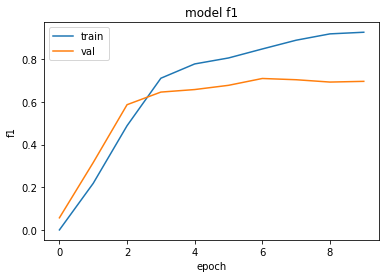

In [36]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Все еще не очень

#### модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [37]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)

BILSTM = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=True),
                        backward_layer=tf.keras.layers.LSTM(64, return_sequences=True, 
                                                            go_backwards=True))(gru_1)
BIGRU = tf.keras.layers.Bidirectional(
                                    tf.keras.layers.GRU(128, return_sequences=True),
                        backward_layer=tf.keras.layers.GRU(64, return_sequences=True, 
                                                            go_backwards=True))(BILSTM)


gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(BIGRU)

lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [38]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          callbacks=[callback],
          epochs=20)

Epoch 1/20
43/43 [==============================] - 33s 554ms/step - loss: 2.3933 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3103 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 22s 511ms/step - loss: 2.0326 - f1: 0.0279 - rec@prec: 0.0063 - val_loss: 1.7863 - val_f1: 0.1160 - val_rec@prec: 0.0654
Epoch 3/20
43/43 [==============================] - 22s 507ms/step - loss: 1.6044 - f1: 0.2167 - rec@prec: 0.1157 - val_loss: 1.6127 - val_f1: 0.2295 - val_rec@prec: 0.1267
Epoch 4/20
43/43 [==============================] - 22s 504ms/step - loss: 1.3900 - f1: 0.4231 - rec@prec: 0.1819 - val_loss: 1.5264 - val_f1: 0.4695 - val_rec@prec: 0.1307
Epoch 5/20
43/43 [==============================] - 22s 508ms/step - loss: 1.2481 - f1: 0.5470 - rec@prec: 0.2888 - val_loss: 1.5932 - val_f1: 0.4542 - val_rec@prec: 0.1366
Epoch 6/20
43/43 [==============================] - 22s 508ms/step - loss: 1.1238 - f1: 0.6167 - rec@prec: 0.4436 - val

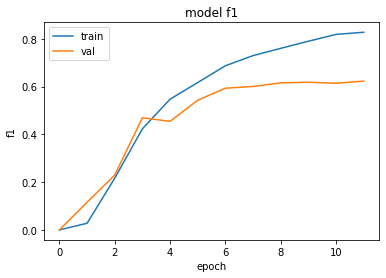

In [39]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Не слишком отличается от других моделей

### Лучшая:

модель с 1 LSTM слоем:  

val_f1: 0.7083 

val_rec@prec: 0.6046

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [40]:
from datasets import load_dataset

In [41]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [72]:
import gensim

In [74]:
w2v = gensim.models.Word2Vec(dataset['train']['tokens'], 
                             vector_size=350, 
                             min_count=25, 
                             max_vocab_size=14000,
                             window=6,
                             epochs=9,
                             sample=1e-5,
                             sg=1,
                             hs=1)

In [75]:
weights = np.zeros((len(word2id), 350))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]
    
    
    except KeyError:
        continue
        weights[i] = w2v.wv['опрагпллирао']

In [73]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [76]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [77]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [78]:
id2word = {i:word for word, i in word2id.items()}

In [80]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [81]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [82]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [83]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [84]:
print(X.shape, X_test.shape)
print(y.shape, y_test.shape)

(20000, 54) (10000, 54)
(20000, 54) (10000, 54)


## модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

In [85]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=350, 
                                       trainable=True,
                                       weights=[weights])(inputs, )

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [86]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          callbacks=[callback],
          epochs=7)

Epoch 1/7
157/157 [==============================] - 18s 73ms/step - loss: 0.2488 - accuracy: 0.9316 - val_loss: 0.1378 - val_accuracy: 0.9546
Epoch 2/7
157/157 [==============================] - 10s 63ms/step - loss: 0.1053 - accuracy: 0.9658 - val_loss: 0.0795 - val_accuracy: 0.9758
Epoch 3/7
157/157 [==============================] - 10s 63ms/step - loss: 0.0434 - accuracy: 0.9862 - val_loss: 0.0516 - val_accuracy: 0.9838
Epoch 4/7
157/157 [==============================] - 10s 63ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.0518 - val_accuracy: 0.9851
Epoch 5/7
157/157 [==============================] - 10s 62ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0583 - val_accuracy: 0.9841
Epoch 6/7
157/157 [==============================] - 10s 63ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0645 - val_accuracy: 0.9837


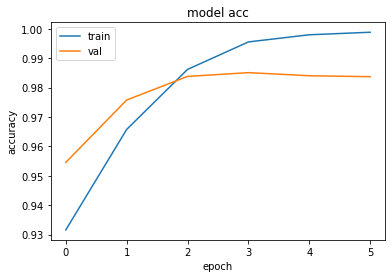

In [87]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [88]:
from sklearn.metrics import classification_report

In [89]:
pred = model.predict(X_test).argmax(2)

In [90]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.93      0.94      0.93     40480
       B-PER       0.91      0.84      0.87      3542
       I-PER       0.95      0.81      0.87      7544
       B-ORG       0.62      0.78      0.69      4074
       I-ORG       0.77      0.83      0.80      8008
       B-LOC       0.76      0.77      0.76      4560
       I-LOC       0.93      0.67      0.78      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.86      0.83      0.84    540000
weighted avg       0.98      0.98      0.98    540000



### Предсказание/Inference

In [93]:
import re

In [94]:
def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [95]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)

[('Алексей', 'B-PER'),
 ('сказал', 'I-PER'),
 ('Светлане', 'I-PER'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('она', 'O'),
 ('собиралась', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [96]:
label_seq('Я поступил в ВШЭ в Москве', word2id, id2labels, MAX_LEN, model)

[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'B-LOC'),
 ('в', 'O'),
 ('Москве', 'B-LOC')]

In [97]:
label_seq('«Спартак» на выезде сыграл с польской «Легией» в матче заключительного тура группового этапа Лиги Европы.', word2id, id2labels, MAX_LEN, model)

[('«', 'O'),
 ('Спартак', 'B-ORG'),
 ('»', 'I-ORG'),
 ('на', 'O'),
 ('выезде', 'O'),
 ('сыграл', 'O'),
 ('с', 'O'),
 ('польской', 'B-ORG'),
 ('«', 'O'),
 ('Легией', 'B-ORG'),
 ('»', 'I-ORG'),
 ('в', 'O'),
 ('матче', 'B-ORG'),
 ('заключительного', 'I-ORG'),
 ('тура', 'I-ORG'),
 ('группового', 'I-ORG'),
 ('этапа', 'O'),
 ('Лиги', 'I-ORG'),
 ('Европы', 'I-ORG'),
 ('.', 'O')]

In [98]:
label_seq('Эта победа гарантировала «Спартаку» попадание в плей-офф Лиги Европы.', word2id, id2labels, MAX_LEN, model)

[('Эта', 'O'),
 ('победа', 'O'),
 ('гарантировала', 'O'),
 ('«', 'O'),
 ('Спартаку', 'B-ORG'),
 ('»', 'O'),
 ('попадание', 'O'),
 ('в', 'O'),
 ('плей', 'B-ORG'),
 ('-', 'O'),
 ('офф', 'B-ORG'),
 ('Лиги', 'I-ORG'),
 ('Европы', 'I-ORG'),
 ('.', 'O')]

## модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев

In [99]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=350, 
                                       trainable=True,
                                       weights=[weights])(inputs, )


l_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
l_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True))(l_1)
l_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(l_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(l_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [100]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          callbacks=[callback],
          epochs=7)

Epoch 1/7
157/157 [==============================] - 7s 30ms/step - loss: 0.2740 - accuracy: 0.9330 - val_loss: 0.1037 - val_accuracy: 0.9662
Epoch 2/7
157/157 [==============================] - 3s 22ms/step - loss: 0.0625 - accuracy: 0.9808 - val_loss: 0.0567 - val_accuracy: 0.9821
Epoch 3/7
157/157 [==============================] - 3s 22ms/step - loss: 0.0218 - accuracy: 0.9941 - val_loss: 0.0511 - val_accuracy: 0.9843
Epoch 4/7
157/157 [==============================] - 4s 23ms/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.0515 - val_accuracy: 0.9849
Epoch 5/7
157/157 [==============================] - 3s 22ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0528 - val_accuracy: 0.9848
Epoch 6/7
157/157 [==============================] - 3s 22ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0554 - val_accuracy: 0.9851


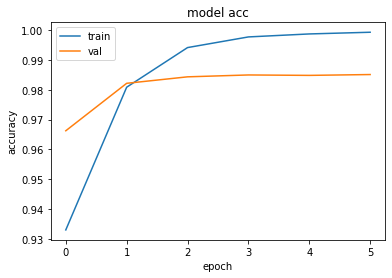

In [101]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [102]:
pred = model.predict(X_test).argmax(2)

In [103]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.93      0.96      0.94     40480
       B-PER       0.86      0.87      0.87      3542
       I-PER       0.92      0.89      0.91      7544
       B-ORG       0.73      0.71      0.72      4074
       I-ORG       0.86      0.75      0.80      8008
       B-LOC       0.71      0.77      0.74      4560
       I-LOC       0.83      0.75      0.79      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.99    540000
   macro avg       0.86      0.84      0.85    540000
weighted avg       0.98      0.99      0.98    540000



### Предсказание/Inference

In [104]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)

[('Алексей', 'B-PER'),
 ('сказал', 'B-PER'),
 ('Светлане', 'I-PER'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('она', 'O'),
 ('собиралась', 'O'),
 ('на', 'O'),
 ('поезд', 'B-LOC'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [105]:
label_seq('Я поступил в ВШЭ в Москве', word2id, id2labels, MAX_LEN, model)

[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'B-ORG'),
 ('в', 'O'),
 ('Москве', 'B-LOC')]

In [106]:
label_seq('«Спартак» на выезде сыграл с польской «Легией» в матче заключительного тура группового этапа Лиги Европы.', word2id, id2labels, MAX_LEN, model)

[('«', 'O'),
 ('Спартак', 'B-ORG'),
 ('»', 'I-ORG'),
 ('на', 'O'),
 ('выезде', 'O'),
 ('сыграл', 'O'),
 ('с', 'O'),
 ('польской', 'B-ORG'),
 ('«', 'O'),
 ('Легией', 'I-ORG'),
 ('»', 'O'),
 ('в', 'O'),
 ('матче', 'O'),
 ('заключительного', 'I-ORG'),
 ('тура', 'I-ORG'),
 ('группового', 'I-ORG'),
 ('этапа', 'I-ORG'),
 ('Лиги', 'I-ORG'),
 ('Европы', 'I-ORG'),
 ('.', 'O')]

In [107]:
label_seq('Эта победа гарантировала «Спартаку» попадание в плей-офф Лиги Европы.', word2id, id2labels, MAX_LEN, model)

[('Эта', 'O'),
 ('победа', 'O'),
 ('гарантировала', 'O'),
 ('«', 'O'),
 ('Спартаку', 'O'),
 ('»', 'O'),
 ('попадание', 'O'),
 ('в', 'O'),
 ('плей', 'O'),
 ('-', 'O'),
 ('офф', 'B-ORG'),
 ('Лиги', 'I-ORG'),
 ('Европы', 'I-ORG'),
 ('.', 'O')]

## Вывод

У BIGRU и метрики лучше, и лучше распознает сущности. Но качество обоих моделей сравнимо с семинарским +-.